# <center> Database Management Project: <br> Recommender System using ALS for implicit Feedback </center>
### <center> Tommy Tran, Thomas de Mareuil, Constantin Vodé - March 2020 </center>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#-Database-Management-Project:--Recommender-System-using-ALS-for-implicit-Feedback-" data-toc-modified-id="-Database-Management-Project:--Recommender-System-using-ALS-for-implicit-Feedback--1"><span class="toc-item-num">1&nbsp;&nbsp;</span><center> Database Management Project: <br> Recommender System using ALS for implicit Feedback </center></a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#-Tommy-Tran,-Thomas-de-Mareuil,-Constantin-Vodé---March-2020-" data-toc-modified-id="-Tommy-Tran,-Thomas-de-Mareuil,-Constantin-Vodé---March-2020--1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span><center> Tommy Tran, Thomas de Mareuil, Constantin Vodé - March 2020 </center></a></span></li></ul></li><li><span><a href="#Parsing-the-Data" data-toc-modified-id="Parsing-the-Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Parsing the Data</a></span></li><li><span><a href="#Loading-and-exploring-the-data-in-Spark" data-toc-modified-id="Loading-and-exploring-the-data-in-Spark-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Loading and exploring the data in Spark</a></span><ul class="toc-item"><li><span><a href="#What-are-the-possible-ratings?" data-toc-modified-id="What-are-the-possible-ratings?-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>What are the possible ratings?</a></span></li><li><span><a href="#What-are-the-minimum-number-of-ratings-per-user-and-minimum-number-of-ratings-per-product-(for-rated-products)?" data-toc-modified-id="What-are-the-minimum-number-of-ratings-per-user-and-minimum-number-of-ratings-per-product-(for-rated-products)?-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>What are the minimum number of ratings per user and minimum number of ratings per product (for rated products)?</a></span></li><li><span><a href="#What-is-the-total-number-of-users-in-the-data-set?" data-toc-modified-id="What-is-the-total-number-of-users-in-the-data-set?-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>What is the total number of users in the data set?</a></span></li><li><span><a href="#What-is-the-total-number-of-products-in-the-data-set?" data-toc-modified-id="What-is-the-total-number-of-products-in-the-data-set?-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>What is the total number of products in the data set?</a></span></li><li><span><a href="#What-are-the-unrated-products?" data-toc-modified-id="What-are-the-unrated-products?-1.2.5"><span class="toc-item-num">1.2.5&nbsp;&nbsp;</span>What are the unrated products?</a></span></li><li><span><a href="#Extracting-relevant-rating-data-as-an-RDD-for-further-analysis" data-toc-modified-id="Extracting-relevant-rating-data-as-an-RDD-for-further-analysis-1.2.6"><span class="toc-item-num">1.2.6&nbsp;&nbsp;</span>Extracting relevant rating data as an RDD for further analysis</a></span></li></ul></li><li><span><a href="#Our-implemention-of-the-ALS-algorithm-in-Spark" data-toc-modified-id="Our-implemention-of-the-ALS-algorithm-in-Spark-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Our implemention of the ALS algorithm in Spark</a></span></li><li><span><a href="#Our-implemention-of-the-eALS-algorithm-in-Spark" data-toc-modified-id="Our-implemention-of-the-eALS-algorithm-in-Spark-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Our implemention of the eALS algorithm in Spark</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Reconstruct-ratings-from-reconstructed-rating-matrix-table-to-compare-with-predicted-ratings" data-toc-modified-id="Reconstruct-ratings-from-reconstructed-rating-matrix-table-to-compare-with-predicted-ratings-1.4.0.1"><span class="toc-item-num">1.4.0.1&nbsp;&nbsp;</span>Reconstruct ratings from reconstructed rating matrix table to compare with predicted ratings</a></span></li></ul></li></ul></li><li><span><a href="#Spark-ALS-using-the-existing-pyspark-library" data-toc-modified-id="Spark-ALS-using-the-existing-pyspark-library-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Spark ALS using the existing pyspark library</a></span><ul class="toc-item"><li><span><a href="#ALS-model-selection-and-evaluation" data-toc-modified-id="ALS-model-selection-and-evaluation-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>ALS model selection and evaluation</a></span></li><li><span><a href="#ALS-Model-Learning-curve" data-toc-modified-id="ALS-Model-Learning-curve-1.5.2"><span class="toc-item-num">1.5.2&nbsp;&nbsp;</span>ALS Model Learning curve</a></span></li><li><span><a href="#Model-testing" data-toc-modified-id="Model-testing-1.5.3"><span class="toc-item-num">1.5.3&nbsp;&nbsp;</span>Model testing</a></span></li></ul></li></ul></li></ul></div>

In [4]:
# spark imports
from pyspark import SparkContext
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.sql.types import StringType, ArrayType
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.recommendation import ALS
from pyspark.ml.recommendation import ALS

# data science imports
import math
import numpy as np
from numpy.random import rand
from numpy import matrix
import pandas as pd
from sklearn import preprocessing

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

# other imports
import sys
import time
from __future__ import print_function
import gzip
from ast import literal_eval
import json
import simplejson

%matplotlib inline

sc = SparkContext('local')
spark = SparkSession(sc)

## Parsing the Data

In [ ]:
# Function to parse the "Cell Phones & Accessories Ratings"" dataset, format .txt,
# downloaded from ... as recommended in ...'s paper.

def parse(filename):
    f = open(filename, 'r')
    entry = {}
    for l in f:
        l = l.strip()
        colonPos = l.find(':')
        if colonPos == -1:
            yield entry
            entry = {}
            continue
        eName = l[:colonPos]
        rest = l[colonPos+2:]
        entry[eName] = rest
    yield entry

    
# Parsing the data

for e in parse("Cell_Phones_&_Accessories.txt"):
    a = simplejson.dumps(e)
    a = literal_eval(a)
    df = pd.DataFrame(a, index=[1,])
    df = df.drop(index=1)
    break;

i=0
for e in parse("Cell_Phones_&_Accessories.txt"):
    i+=1
    b = simplejson.dumps(e)
    b = literal_eval(b)

    b = pd.DataFrame(b, index=[1,])
    df = df.append(b, ignore_index=True)
    if i==1000:
        break;
        

# Encoding products Ids (label encoding)

le = preprocessing.LabelEncoder()
le.fit(df['product/productId'])
le.classes_
df['product/productId'] = le.transform(df['product/productId'])

# Encoding users Ids (label encoding)

le = preprocessing.LabelEncoder()
le.fit(df['review/userId'])
le.classes_
df['review/userId'] = le.transform(df['review/userId'])


# Saving as .csv

df.to_csv('ratings.csv', index=False)

df = pd.read_csv('ratings.csv')
df.head()

## Loading and exploring the data in Spark

In [22]:
# spark config
spark = SparkSession \
    .builder \
    .appName("movie recommendation") \
    .config("spark.driver.maxResultSize", "96g") \
    .config("spark.driver.memory", "96g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.master", "local[12]") \
    .getOrCreate()

# get spark context
sc = spark.sparkContext

In [24]:
ratings = spark.read.load('ratings.csv', format='csv', header=True, inferSchema=True)
ratings.show()

+-----------------+--------------------+-------------+-------------+--------------------+------------------+------------+-----------+--------------------+--------------------+
|product/productId|       product/title|product/price|review/userId|  review/profileName|review/helpfulness|review/score|review/time|      review/summary|         review/text|
+-----------------+--------------------+-------------+-------------+--------------------+------------------+------------+-----------+--------------------+--------------------+
|              741|Mobile Action MA7...|      unknown|         1935|             A. Igoe|               0/0|         1.0| 1233360000|          Don't buy!|First of all, the...|
|              741|Mobile Action MA7...|      unknown|         7295|        Steven Martz|               0/0|         5.0| 1191456000|Mobile Action Blu...|Great product- tr...|
|              741|Mobile Action MA7...|      unknown|         4031|"Daniel M. Johnso...|               0/0|         4.0

### What are the possible ratings?

In [25]:
print('Distinct values of ratings:')
print(sorted(ratings.select('review/score').distinct().rdd.map(lambda r: r[0]).collect()))

Distinct values of ratings:
[' & Books"""', ' and Roll!"""', ' etc."""', ' gadget guy"""', '0/0', '1.0', '1/1', '1/2', '1/3', '13/14', '15/16', '2.0', '2/3', '20/21', '3.0', '3/3', '3/4', '4.0', '5.0', '5/5', '5/6', '5/7', '6/7', '6/9', '8/11', '8/8', '9/9']


We will convert the ratings later so that they can be processed.

### What are the minimum number of ratings per user and minimum number of ratings per product (for rated products)?

In [26]:
tmp1 = ratings.groupBy("review/userid").count().toPandas()['count'].min()
tmp2 = ratings.groupBy("product/title").count().toPandas()['count'].min()
print('For the users that rated products and the products that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per product is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 1
Minimum number of ratings per movie is 1


### What is the total number of users in the data set?

In [27]:
tmp3 = ratings.select('review/userid').distinct().count()
print('We have a total of {} distinct users in the data set'.format(tmp3))

We have a total of 9245 distinct users in the data sets


### What is the total number of products in the data set?

In [28]:
tmp4 = ratings.select('product/productid').distinct().count()
print('We have a total of {} distinct products in the data set'.format(tmp4))

We have a total of 976 distinct products in the data sets


### What are the unrated products?

In [29]:
# We create a temp SQL table view for easier query:
ratings.createOrReplaceTempView("ratings")

print('List of products that are not rated yet: ')

# SQL query (NOTE: WHERE ... NOT IN ... == ... LEFT JOIN ... WHERE ... IS NULL)

# Approach 1
spark.sql(
    "SELECT `product/productid`, `product/title`"
    "FROM ratings "
).show(10)

# Approach 2
# spark.sql(
#     "SELECT m.movieId, m.title "
#     "FROM movies m LEFT JOIN ratings r ON m.movieId=r.movieId "
#     "WHERE r.movieId IS NULL"
# ).show(10)

List product that are not rated yet: 
+-----------------+--------------------+
|product/productid|       product/title|
+-----------------+--------------------+
|              741|Mobile Action MA7...|
|              741|Mobile Action MA7...|
|              741|Mobile Action MA7...|
|              372|USB Data Cable fo...|
|              372|USB Data Cable fo...|
|              372|USB Data Cable fo...|
|              372|USB Data Cable fo...|
|              372|USB Data Cable fo...|
|              372|USB Data Cable fo...|
|              372|USB Data Cable fo...|
+-----------------+--------------------+
only showing top 10 rows



### Extracting relevant rating data as an RDD for further analysis

In [5]:
# File location and type
file_location = "ratings.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "false"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

rating_data = df.rdd

header = rating_data.take(1)[0]

rating_data = rating_data \
    .filter(lambda line: line!=header) \
    .map(lambda x: list(x))\
    .map(lambda x: (int(x[3]), int(x[0]), x[6].split('/')[0])) \
    .filter(lambda x: x[2]!=' and Roll!"""') \
    .filter(lambda x: x[2]!=' & Books"""') \
    .filter(lambda x: x[2]!=' etc."""') \
    .filter(lambda x: x[2]!=' gadget guy"""') \
    .map(lambda x: (x[0], x[1], float(x[2])))\
    .cache()

#rating_data.collect()

## Our implemention of the ALS algorithm in Spark

In [6]:
#Additional functions

def set_data_matrix(M, data_list):
    for data in data_list:
        M[data[0], data[1]] = data[2]
    return M

def update(i, mat, ratings): # i = x, mat = V if caculate U, rating is M.
    uu = mat.shape[0]
    ff = mat.shape[1]

    XtX = mat.T * mat # projection matrix
    Xty = mat.T * ratings[i, :].T

    for j in range(ff):
        XtX[j, j] += LAMBDA * uu

    return np.linalg.solve(XtX, Xty)

def rmse(R, ms, us):
    diff = R - ms * us.T
    return np.sqrt(np.sum(np.power(diff, 2)) / (M * U)
                  )

In [7]:
# re-init spark
spark = SparkSession\
        .builder\
        .appName("PythonALS")\
        .getOrCreate()

sc = spark.sparkContext

In [8]:
rating_list = rating_data.collect()

LAMBDA = 0.01   # regularization

U = len(pd.read_csv('ratings.csv')['product/productId'].unique()) # nb of items
M = len(pd.read_csv('ratings.csv')['review/userId'].unique()) # nb of users
F = 8 # latent vector    
num_iters = 10
partitions = 2

R = np.full((M, U), 0, dtype=np.float64)
R = matrix(set_data_matrix(R, rating_list)) # M

In [9]:
users = matrix(np.full((M, F), 1.0)) # U users matrix
product = matrix(np.full((U, F), 1.0)) # V product matrix

Rb = sc.broadcast(R)
users_b = sc.broadcast(users)
product_b = sc.broadcast(product)

for i in range(num_iters):
    users = sc.parallelize(range(M), partitions) \
           .map(lambda x: update(x, product_b.value, Rb.value)) \
           .collect() # U, x = row number
    # collect() returns a list, so array ends up being
    # a 3-d array, we take the first 2 dims for the matrix
    users = matrix(np.array(users)[:, :, 0]) # U
    users_b = sc.broadcast(users)

    product = sc.parallelize(range(U), partitions) \
           .map(lambda x: update(x, users_b.value, Rb.value.T)) \
           .collect() # V, x = columns
    product = matrix(np.array(product)[:, :, 0])
    product_b = sc.broadcast(product)

    error = rmse(R, users, product)

#print("Iteration %d:" % i)
print("R= %s:" % (str(R))) 
print("ms= %s:" % (str(users)))   
print('\n\n')
print("us= %s:" % (str(product)))           
#print("\nRMSE: %5.4f\n" % error)
print("RMSE=%.4f" % error)

R= [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [4. 2. 5. ... 0. 0. 0.]]:
ms= [[2.25425806e-14 2.25425806e-14 2.25425806e-14 ... 2.25425806e-14
  2.25425806e-14 2.25425806e-14]
 [1.27787654e-02 1.27787654e-02 1.27787654e-02 ... 1.27787654e-02
  1.27787654e-02 1.27787654e-02]
 [2.29777572e-03 2.29777572e-03 2.29777572e-03 ... 2.29777572e-03
  2.29777572e-03 2.29777572e-03]
 ...
 [4.59555144e-04 4.59555144e-04 4.59555144e-04 ... 4.59555144e-04
  4.59555144e-04 4.59555144e-04]
 [1.13630378e-03 1.13630378e-03 1.13630378e-03 ... 1.13630378e-03
  1.13630378e-03 1.13630378e-03]
 [4.22484105e-01 4.22484105e-01 4.22484105e-01 ... 4.22484105e-01
  4.22484105e-01 4.22484105e-01]]:



us= [[6.99674285e-03 6.99674285e-03 6.99674285e-03 ... 6.99674285e-03
  6.99674285e-03 6.99674285e-03]
 [3.57073218e-03 3.57073218e-03 3.57073218e-03 ... 3.57073218e-03
  3.57073218e-03 3.57073218e-03]
 [8.76647815e-03 8.76647815e-0

##  Our implemention of the eALS algorithm in Spark

In [10]:
#re-init spark
spark = SparkSession\
        .builder\
        .appName("Python_eALS")\
        .getOrCreate()

sc = spark.sparkContext

In [19]:
def set_data_matrix(M, data_list):
    for data in data_list:
        M[data[0], data[1]] = data[2]
    return M

def update_user(u, U, V, R, SU, SV):
    itemList = nb_items
    SU_bis = SU.value
    SV_bis = SV.value

    # prediction cache for the user
    for i in range(itemList):
        prediction_items[i] = U[u]@V[i];
        rating_items[i] = R[u][i];
        w_items[i] = W[u][i]

    oldVector = R[u]
    for f in range(factors):
        numer = 0
        denom = 0
        
        #O(K) complexity for the negative part
        for k in range(factors):
            if k != f:
                numer -= U[u][ k] * SV_bis[f][k]
        

        #O(Nu) complexity for the positive part
        for i in range(itemList):
            prediction_items[i] -= U[u][f] * V[i][f]
            numer +=  (w_items[i]*rating_items[i] - (w_items[i]-Wi[i]) * prediction_items[i]) * V[i][f]
            denom += (w_items[i]-Wi[i]) * V[i][f] * V[i][f]
        denom += SV_bis[f][f] + reg;

        #Parameter Update
        U[u][f] = numer / denom

        #Update the prediction cache
        for i in range(itemList):
            prediction_items[i] += U[u][f] * V[i][f]

    #Update the SU cache
    for f in range(factors):
        for k in range(factors):
            val = SU_bis[f][k] - oldVector[f] * oldVector[k] + U[u][f] * U[u][k]
            SU_bis[f][k] = val
            SU_bis[k][f] = val
    #SU = sc.broadcast(SU_bis)
    return U[u]

In [20]:
def update_item(i, V, U, R, SU, SV):
    userList = nb_users
    SU_bis = SU.value
    SV_bis = SV.value

    # prediction cache for the user
    for u in range(userList):
        prediction_users[u] = U[u]@V[i]
        rating_users[u] = R[u][i]
        w_users[u] = W[u][i]

    oldVector = R[i]
    for f in range(factors):
        numer = 0
        denom = 0
        
        #O(K) complexity for the negative part
        for k in range(factors):
            if k != f:
                numer -= V[i][ k] * SU_bis[f][k]
        

        #O(Nu) complexity for the positive part
        for u in range(userList):
            prediction_users[u] -= U[u][f] * V[i][f]
            numer +=  (w_users[u]*rating_users[u] - (w_users[i]-Wi[i]) * prediction_users[u]) * U[u][f]
            denom += (w_users[i]-Wi[i]) * U[u][f] * U[u][f]
        denom += SU_bis[f][f] + reg;

        #Parameter Update
        V[i][f] = numer / denom

        #Update the prediction cache
        for u in range(userList):
            prediction_users[u] += U[u][f] * V[i][f]

    #Update the SV cache
    for f in range(factors):
        for k in range(factors):
            val = SV_bis[f][k] - oldVector[f] * oldVector[k] * Wi[i] + V[i][f]*V[i][k]*Wi[i]
            SV_bis[f][k] = val
            SV_bis[k][f]= val
    #SV = sc.broadcast(SV_bis)
        
    return V[i]

In [13]:
rating_list = rating_data.collect()

In [24]:
partitions = 10

#/** Model priors to set. */
factors = 10 # number of latent factors.
maxIter = 20 #maximum iterations.
reg = 0.01 #regularization parameters
init_mean = 0;  # Gaussian mean for init V
init_stdev = 0.01 #Gaussian std-dev for init V
nb_items = len(pd.read_csv('ratings.csv')['product/productId'].unique()) #items
nb_users = len(pd.read_csv('ratings.csv')['review/userId'].unique()) #users


R = np.full((nb_users, nb_items), 0, dtype=np.float64)
R = matrix(set_data_matrix(R, rating_list)) #M
R = np.array(R)

#// Set the Wi as a decay function w0 * pi ^ alpha
w0 = 1
s = 0 
Z = 0
alpha = 1
p = [0 for i in range(nb_items)]

for i in range(nb_items):
    p[i] = sum(R[0]!=0) #Nb items by user
    s += p[i]
# convert p[i] to probability 
for i in range(nb_items):
    p[i] = p[i]/s;
   # p[i] = p[i]**alpha;
    Z += p[i];
#assign weight
Wi = [0 for i in range(nb_items)];
for i in range(nb_items):
    Wi[i] = w0 * p[i] / Z;
#By default, the weight for positive instance is uniformly 1.
W = np.full((nb_users, nb_items), 0, dtype=np.float64)
for u in range(nb_users):
    for i in R[u]:
        W[u][int(i)]= 1 

        
#Init caches
prediction_users = [0 for i in range(nb_users)];
prediction_items = [0 for i in range(nb_items)];
rating_users = [0 for i in range(nb_users)];
rating_items = [0 for i in range(nb_items)];
w_users = [0 for i in range(nb_users)];
w_items = [0 for i in range(nb_items)];

#Init model parameters
users = np.random.normal(init_mean, init_stdev, nb_users*factors).reshape((nb_users,factors))#latent vectors for users
product = np.random.normal(init_mean, init_stdev, nb_items*factors).reshape((nb_items, factors)) #latent vectors for items
SU = users.T@users
SV = np.full((factors, factors), 0, dtype=np.float64)
for f in range(factors):
    for k in range(factors):
        val = 0;
        for i in range(nb_items):
            val += product[i][f] * product[i][k]* Wi[i]
        SV[f][k] = val
        SV[k][f] = val


In [ ]:
user_b = users
product_b = product
Rb = R
SU = sc.broadcast(SU)
SV = sc.broadcast(SV)


for v in range(maxIter):
    users = sc.parallelize(range(nb_users), partitions) \
               .map(lambda u: update_user(u, user_b, product_b, Rb, SU, SV)) \
               .collect() #u user id, 
    users_b = users

    
    product = sc.parallelize(range(nb_items), partitions) \
               .map(lambda i: update_item(i, product_b, user_b, Rb, SU, SV)) \
               .collect() #V, x = columns
    product_b = product    

In [49]:
def rmse_bis(R, ms, us):
    diff = R - ms@us.T
    return np.sqrt(np.sum(np.power(diff, 2)) / (nb_users * nb_items))
                   
rmse_bis(R, np.matrix(users), np.matrix(product))

0.12399402466204804

#### Reconstruct ratings from reconstructed rating matrix table to compare with predicted ratings

In [14]:
R_reconstructed = np.matrix(users)@np.matrix(product).T
r = pd.DataFrame(columns=['item_id', 'user_id', 'rate'])


for line in rating_list:
    product_j = line[1]
    user_i = line[0]
    rate = float(R_reconstructed[user_i].reshape(R_reconstructed[product_j].shape[1],1)[product_j])
    r = r.append(pd.DataFrame(np.array([[int(product_j), int(user_i), rate]]), columns=['item_id', 'user_id', 'rate']), ignore_index=True)

In [18]:
from math import floor
r.rate = r.rate.apply(lambda x: round(x,1) if (x>0) else 0)

## Spark ALS using the existing pyspark library

### ALS model selection and evaluation

In [21]:
ratings = spark.createDataFrame(rating_data)
(train, test) = ratings.randomSplit([0.8, 0.2])

# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=5, regParam=0.01, userCol="_1", itemCol="_2", ratingCol="_3",
          coldStartStrategy="drop")
model = als.fit(train)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="_3",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 3.120677240286891


In [22]:
# Generate top 10 product recommendations for each user
userRecs = model.recommendForAllUsers(10)
# Generate top 10 user recommendations for each product
movieRecs = model.recommendForAllItems(10)

In [26]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # train ALS model
            als = ALS(maxIter=num_iters, regParam=reg, userCol="_1", itemCol="_2", ratingCol="_3",
              coldStartStrategy="drop")
            model = als.fit(train)
            # make prediction
            predictions = model.transform(test)
            evaluator = RegressionEvaluator(metricName="rmse", labelCol="_3",
                                predictionCol="prediction")
            rmse = evaluator.evaluate(predictions)
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, rmse))
            if rmse < min_error:
                min_error = rmse
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [27]:
# hyper-param config
num_iterations = 10
ranks = [8, 10, 12, 14, 16, 18, 20]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train, test, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

8 latent factors and regularization = 0.001: validation RMSE is 3.3331102801915704
8 latent factors and regularization = 0.01: validation RMSE is 2.9467707735746833
8 latent factors and regularization = 0.05: validation RMSE is 2.816589387154773
8 latent factors and regularization = 0.1: validation RMSE is 2.7352330477000217
8 latent factors and regularization = 0.2: validation RMSE is 2.6822093319222815
10 latent factors and regularization = 0.001: validation RMSE is 3.3331102801915704
10 latent factors and regularization = 0.01: validation RMSE is 2.9467707735746833
10 latent factors and regularization = 0.05: validation RMSE is 2.816589387154773
10 latent factors and regularization = 0.1: validation RMSE is 2.7352330477000217
10 latent factors and regularization = 0.2: validation RMSE is 2.6822093319222815
12 latent factors and regularization = 0.001: validation RMSE is 3.3331102801915704
12 latent factors and regularization = 0.01: validation RMSE is 2.9467707735746833
12 latent fa

### ALS Model Learning curve

In [30]:
def plot_learning_curve(arr_iters, train_data, validation_data, reg, rank):
    """
    Plot function to show learning curve of ALS
    """
    errors = []
    for num_iters in arr_iters:
        # train ALS model
        als = ALS(maxIter=num_iters, regParam=reg, userCol="_1", itemCol="_2", ratingCol="_3",
          coldStartStrategy="drop")
        model = als.fit(train)
        # make prediction
        predictions = model.transform(test)
        evaluator = RegressionEvaluator(metricName="rmse", labelCol="_3",
                            predictionCol="prediction")
        rmse = evaluator.evaluate(predictions)
        errors.append(rmse)

    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(arr_iters, errors)
    plt.xlabel('number of iterations')
    plt.ylabel('RMSE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.show()

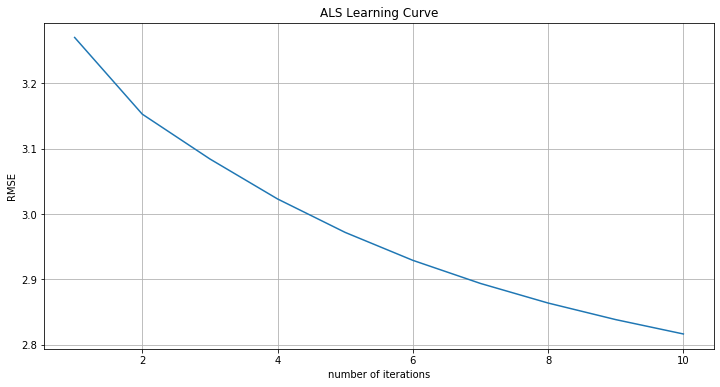

In [31]:
# create an array of num_iters
iter_array = list(range(1, 11))
# create learning curve plot
plot_learning_curve(iter_array, train, test, 0.05, 20)

### Model testing

In [32]:
# Evaluate the final model by computing the RMSE on the test data
predictions = final_model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="_3",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 2.6822093319222815
